<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Figure 1: Observed and modelled forest risks

_Authors: Oriana Chegwidden and Jeremy Freeman_

The methods below conduct the analyses to recreate Figure 1 included the
manuscript <<< insert doi >>>. They draw from a model data produced by running
`../../../scripts/fire.py` to create a the file located at
`az:carbonplan-scratch/data/fire.zarr`.


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy as sp
from carbonplan_forest_risks import load, setup, plot, fit, utils, prepare, collect
import xarray as xr
from carbonplan_forest_risks.utils import get_store
import altair as alt
import rioxarray
from carbonplan.data import cat
from carbonplan_styles.mpl import get_colormap
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

from carbonplan_data import utils
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Initialize the dictionary where you'll store all of your datasets.


In [2]:
ds_dict = {}

## Load in the fire data


In [3]:
coarsen = 4
store = "az"
tlim = ("1984", "2018")

#### Historical simulation


In [4]:
historical_fire = xr.open_zarr(
    get_store(
        "carbonplan-forests", "risks/results/paper/fire_terraclimate.zarr"
    )
)

In [5]:
fire_mask = ~np.isnan(historical_fire.historical.isel(time=0).drop("time"))

In [6]:
ds_dict["Fire_modeled"] = (
    xr.open_zarr(
        get_store(
            "carbonplan-forests",
            "risks/results/paper/fire_terraclimate.zarr",
        )
    )
    .groupby("time.year")
    .sum()
    .where(fire_mask)
    .mean(dim="year")
).compute()["historical"]

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


#### Observations


In [8]:
mask = (
    load.nlcd(store=store, year=2001).sel(band=[41, 42, 43, 90]).sum("band")
    > 0.25
).astype("float")

In [9]:
ds_dict["Fire_observed"] = load.mtbs(
    store=store, coarsen=coarsen, tlim=tlim, mask=mask
)
ds_dict["Fire_observed"] = (
    ds_dict["Fire_observed"]
    .assign_coords(
        {"x": ds_dict["Fire_modeled"].x, "y": ds_dict["Fire_modeled"].y}
    )
    .assign_coords(
        {
            "lat": ds_dict["Fire_modeled"].lat,
            "lon": ds_dict["Fire_modeled"].lon,
        }
    )
    .groupby("time.year")
    .sum()
    .where(fire_mask)
    .mean(dim="year")
).compute()["monthly"]

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Load in insect and drought data


In [21]:
base_url_tempate = (
    "https://carbonplan.blob.core.windows.net/carbonplan-forests/risks/results/paper/insects_and_drought_eval/{}"
)
dataset_urls = {
    "Drought": {
        "modeled": base_url_tempate.format(
            "Fig1D_DroughtModel_ModeledFIAlongEnsembleHistMort_04-22-2021.tiff"
        ),
        "observed": base_url_tempate.format(
            "Fig1C_DroughtModel_FIAwide-ObsMort_05-08-2021.tiff"
        ),
    },
    "Insects": {
        "modeled": base_url_tempate.format(
            "Fig1F_InsectModel_ModeledFIAlongEnsembleHistMort_04-22-2021.tiff"
        ),
        "observed": base_url_tempate.format(
            #             "Fig1E_InsectModel_ObservedHistMort_3-30-2021.tif"
            #             "Fig1E_InsectModel_ObservedHistMort_04-09-2021.tif"
            "Fig1E_InsectModel_FIAwide-ObsMort_05-08-2021.tiff")
    },
}

## Load in the drought and insect data


#### Observations and Historical simulations


In [22]:
for mechanism, url_dict in dataset_urls.items():
    for setup, url in url_dict.items():
        print(url)
        ds_dict[mechanism + "_" + setup] = load.tiff(url, mask, coarsen=1) * 100

https://carbonplan.blob.core.windows.net/carbonplan-forests/risks/results/paper/insects_and_drought_eval/Fig1D_DroughtModel_ModeledFIAlongEnsembleHistMort_04-22-2021.tiff
https://carbonplan.blob.core.windows.net/carbonplan-forests/risks/results/paper/insects_and_drought_eval/Fig1C_DroughtModel_FIAwide-ObsMort_05-08-2021.tiff
https://carbonplan.blob.core.windows.net/carbonplan-forests/risks/results/paper/insects_and_drought_eval/Fig1F_InsectModel_ModeledFIAlongEnsembleHistMort_04-22-2021.tiff
https://carbonplan.blob.core.windows.net/carbonplan-forests/risks/results/paper/insects_and_drought_eval/Fig1E_InsectModel_FIAwide-ObsMort_05-08-2021.tiff


## Plot the figure for all three impacts


In [23]:
plot_params = {
    "Fire": {
        "cmap": get_colormap("reds"),
        "var_lims": (0, 0.004),
        "label": "Burn area\n(fraction/year)",
        "panel": ["A", "B"],
        "cbar_ylocation": 0.76,
    },
    "Drought": {
        "cmap": get_colormap("pinks"),
        "var_lims": (0, 2),
        "label": "Drought-related\nmortality (%/year)",
        "panel": ["C", "D"],
        "cbar_ylocation": 0.4,
    },
    "Insects": {
        "cmap": get_colormap("blues"),
        "var_lims": (0, 0.4),
        "label": "Insect-related\nmortality (%/year)",
        "panel": ["E", "F"],
        "cbar_ylocation": 0.04,
    },
}

In [24]:
matplotlib.rc("font", family="sans-serif")
matplotlib.rc("font", serif="Helvetica Neue")
matplotlib.rc("text", usetex="false")
matplotlib.rcParams.update({"font.size": 14, "svg.fonttype": "none"})

<ipython-input-25-cd481349560d>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=-6)


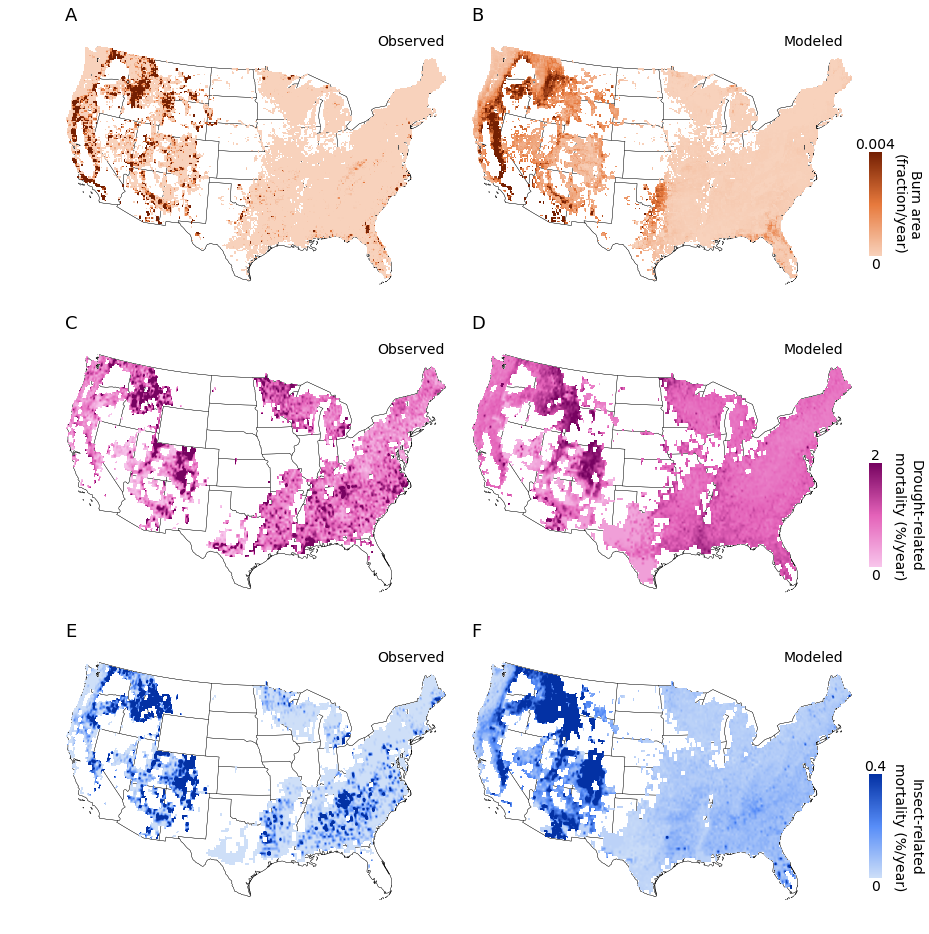

In [25]:
fig, axarr = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(10, 12),
    subplot_kw={"projection": plot.cartopy_proj_albers()},
)
for row, impact in enumerate(["Fire", "Drought", "Insects"]):
    for column, setup in enumerate(["observed", "modeled"]):
        vmin, vmax = (
            plot_params[impact]["var_lims"][0],
            plot_params[impact]["var_lims"][1],
        )
        map_plot = ds_dict["{}_{}".format(impact, setup)].plot.imshow(
            ax=axarr[row, column],
            cmap=plot_params[impact]["cmap"],
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False,
        )
        plot.map_pretty(axarr[row, column], title=setup.capitalize())
        axarr[row, column].text(
            0.12,
            1.05,
            plot_params[impact]["panel"][column],
            transform=axarr[row, column].transAxes,
            fontsize=18,
        )
    plot.add_colorbar(
        fig,
        to_plot=map_plot,
        y_location=plot_params[impact]["cbar_ylocation"],
        vmin=plot_params[impact]["var_lims"][0],
        vmax=plot_params[impact]["var_lims"][1],
        cbar_label=plot_params[impact]["label"],
    )
plt.tight_layout(pad=-6)